# ISA 444 Final Project - Forecasting Models Code
## By John Hicks, Caleb Vowell, & Mia Weber



### 1) Setup & Data Loading

#### Import libraries

In [1]:
!pip install statsforecast mlforecast neuralforecast timecopilot torch lightgbm xgboost utilsforecast

In [2]:
import os
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import timedelta
from functools import partial

# TimeCopilot
from timecopilot import TimeCopilotForecaster
from timecopilot.models.foundation.chronos import Chronos
from timecopilot.models.foundation.moirai import Moirai
from timecopilot.models.foundation.timesfm import TimesFM
from timecopilot.models.stats import (
    AutoARIMA as TCAutoARIMA,
    SeasonalNaive as TCSeasonalNaive,
)

# StatsForecast
from statsforecast import StatsForecast
from statsforecast.models import Naive, SeasonalNaive, AutoETS, AutoARIMA

# MLForecast
from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor

# NeuralForecast
from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoNBEATS, AutoNHITS
from neuralforecast.losses.pytorch import MAE as MAETrain

# Metrics & evaluation
from sklearn.metrics import mean_absolute_error, mean_squared_error
from utilsforecast.evaluation import evaluate
from utilsforecast.losses import rmse, mae as mae_metric, mase, scaled_crps

 See https://github.com/google-research/timesfm/blob/master/README.md for updated APIs.


W1205 04:08:22.807000 1794 torch/utils/cpp_extension.py:117] No CUDA runtime is found, using CUDA_HOME='/usr/local/cuda'


#### Load downsampled_df.csv

In [4]:
df = pd.read_csv("downsampled_df.csv", parse_dates=["ds"])

print(df.head())
print("Number of series:", df["unique_id"].nunique())

  unique_id         ds          y
0      10_2 2010-02-05  123952.48
1      10_2 2010-02-12  119209.48
2      10_2 2010-02-19  121430.80
3      10_2 2010-02-26  120292.15
4      10_2 2010-03-05  113163.91
Number of series: 40


#### Plot all time series

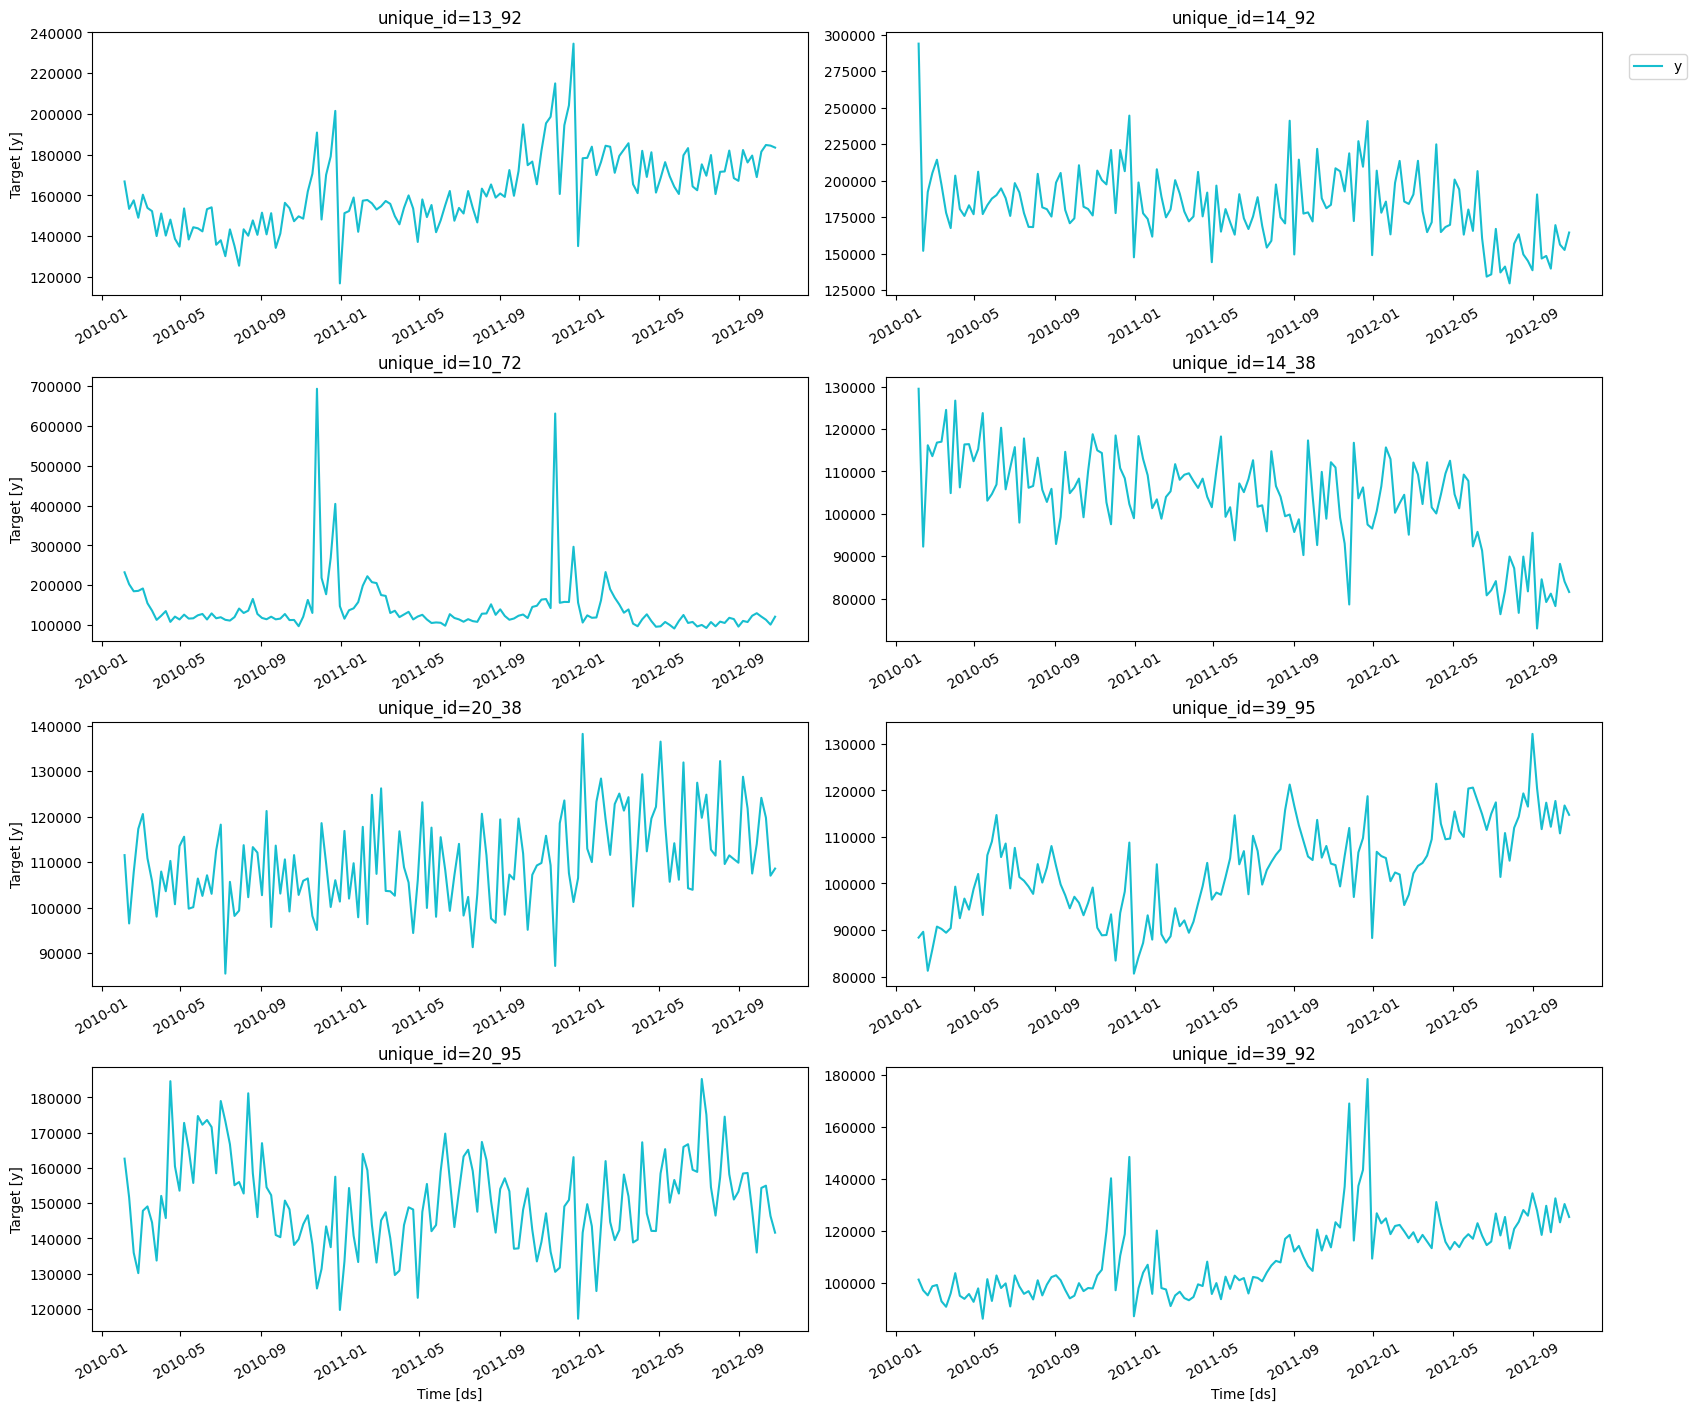

In [5]:
TimeCopilotForecaster.plot(df)

### 2) StatsForecast Models (Naive, Seasonal Naive, AutoETS, & AutoARIMA) Using 5-Fold Cross-Validation

In [6]:
CSV_PATH = "downsampled_df.csv"

df_sf = pd.read_csv(CSV_PATH)

# ensure columns exist
expected_cols = {"unique_id", "ds", "y"}
missing = expected_cols - set(df_sf.columns)
if missing:
    raise ValueError(f"CSV is missing columns: {missing}. Expected: {expected_cols}")

# parse dates and sort
df_sf["ds"] = pd.to_datetime(df_sf["ds"])
df_sf = df_sf.sort_values(["unique_id", "ds"]).reset_index(drop=True)

Y_df = df_sf[["unique_id", "ds", "y"]]

# global CV config
freq = "W"          # weekly data
h = 13              # forecast horizon (weeks)
n_windows = 5       # 5-fold
step_size = h       # non-overlapping

print("\n================ STATSFORECAST MODELS ================")

sf = StatsForecast(
    models=[
        Naive(),
        SeasonalNaive(season_length=52),
        AutoETS(season_length=52),
        AutoARIMA(season_length=52),
    ],
    freq=freq,
    n_jobs=1,   # keep 1 to avoid multiprocessing issues
)

cv_sf = sf.cross_validation(
    df=Y_df,
    h=h,
    n_windows=n_windows,
    step_size=step_size,   # non-overlapping windows
)

sf_metrics = evaluate(
    cv_sf.drop(columns="cutoff"),
    metrics=[rmse, mae_metric],
)

print("StatsForecast metrics (Naive, SNaive, AutoETS, AutoARIMA):")
print(sf_metrics)


================ STATSFORECAST MODELS ================
StatsForecast metrics (Naive, SNaive, AutoETS, AutoARIMA):
   unique_id metric         Naive  SeasonalNaive       AutoETS     AutoARIMA
0       10_2   rmse  11439.611995    4942.558329   8059.653092   8481.825348
1      10_40   rmse   6034.598758    3646.311859   5865.557464   6328.346455
2      10_72   rmse  67852.753548   30267.056204  33208.505603  67802.056966
3      13_90   rmse  12199.775745   13064.951950  10078.438032   9445.983725
4      13_92   rmse  20638.236597   21444.050393  16508.169241  16959.092555
..       ...    ...           ...            ...           ...           ...
75     41_92    mae  13667.225846   10943.848923   9582.958128   9821.215354
76      4_72    mae  20239.428154   14752.358615  14616.735667  21551.371764
77      4_92    mae  19027.837846   17541.977231  12141.451817  11030.120396
78      4_95    mae   9789.131231   11808.939077   9870.530870   9685.632211
79      6_92    mae  10818.877692    7

### 3) Machine Learning Model: LightGBM (MLForecast) Using Walmart train/features/stores

In [7]:
train = pd.read_csv("train.csv")
features = pd.read_csv("features.csv")
stores = pd.read_csv("stores.csv")

train["Date"] = pd.to_datetime(train["Date"])
features["Date"] = pd.to_datetime(features["Date"])

# merge Walmart data
full = (
    train
    .merge(features, on=["Store", "Date", "IsHoliday"], how="left")
    .merge(stores, on="Store", how="left")
)

# build unique_id and Nixtla format
full["unique_id"] = full["Store"].astype(str) + "_" + full["Dept"].astype(str)
full = full.rename(columns={"Date": "ds", "Weekly_Sales": "y"})

panel = full[["unique_id", "ds", "y"]].copy()
panel = panel.sort_values(["unique_id", "ds"]).reset_index(drop=True)

def make_regular_weekly_panel(df_panel, freq="W-FRI"):
    out = []
    for uid, g in df_panel.groupby("unique_id"):
        g = g.sort_values("ds").set_index("ds")
        full_idx = pd.date_range(g.index.min(), g.index.max(), freq=freq)
        g = g.reindex(full_idx)
        g["unique_id"] = uid
        g["y"] = g["y"].fillna(0)
        g = g.reset_index().rename(columns={"index": "ds"})
        out.append(g)
    return pd.concat(out, ignore_index=True)

freq_ml = "W-FRI"
Y_reg = make_regular_weekly_panel(panel, freq=freq_ml)

# filter short series
h = 13
n_windows = 5
max_lag = 52
min_len = n_windows*h + max_lag

lengths = Y_reg.groupby("unique_id")["ds"].size()
good_ids = lengths[lengths >= min_len].index
Y_ml = Y_reg[Y_reg["unique_id"].isin(good_ids)].reset_index(drop=True)

# custom date features for MLForecast
date_features = {
    "week": lambda x: x.dt.isocalendar().week.astype(int),
    "month": lambda x: x.dt.month.astype(int),
}

mlf = MLForecast(
    models=[
        LGBMRegressor(
            n_estimators=200,
            learning_rate=0.05,
            max_depth=-1,
            subsample=0.8,
            colsample_bytree=0.8,
            objective="regression",
            n_jobs=-1,
        )
    ],
    freq=freq_ml,
    lags=[1, 2, 3, 4, 7, 13, 26, 52],
    target_transforms=[],
    date_features=date_features,
)

# fit LightGBM
mlf.fit(
    df=Y_ml,
    id_col="unique_id",
    time_col="ds",
    target_col="y",
)

# 5-fold CV
cv_ml = mlf.cross_validation(
    df=Y_ml,
    n_windows=n_windows,
    h=h,
    id_col="unique_id",
    time_col="ds",
    target_col="y",
    step_size=h,
)

ml_metrics = evaluate(
    cv_ml.drop(columns="cutoff"),
    metrics=[rmse, mae_metric],
)

print("LightGBM 5-fold CV metrics:")
print(ml_metrics)

[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.029264 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2106
[LightGBM] [Info] Number of data points in the train set: 276106, number of used features: 10
[LightGBM] [Info] Start training from score 15512.113325
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008100 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2074
[LightGBM] [Info] Number of data points in the train set: 77531, number of used features: 10
[LightGBM] [Info] Start training from score 15382.490334
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011455 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 2090
[LightGBM] [Info] Number of data points in the train set: 117246, number of used features: 10
[LightGBM] [Info]

### 4) Deep Learning Models: AutoNBEATS & AUtoNHITS (NeuralForecast)

In [8]:
# use a single CV window for shorter series (computationally heavy)
n_windows_nf = 1
step_size_nf = h

print("\n================ NEURALFORECAST (AutoNBEATS & AutoNHITS) ================")

try:
    models_nf = [
        AutoNBEATS(
            h=h,
            loss=MAETrain(),
            num_samples=2,
            backend="optuna",
        ),
        AutoNHITS(
            h=h,
            loss=MAETrain(),
            num_samples=2,
            backend="optuna",
        ),
    ]

    nf = NeuralForecast(
        models=models_nf,
        freq=freq_ml,
    )

    cv_nf = nf.cross_validation(
        Y_df,
        n_windows=n_windows_nf,
        step_size=step_size_nf,
        refit=1,
    )

    nf_metrics = evaluate(
        cv_nf.drop(columns="cutoff"),
        metrics=[rmse, mae_metric],
    )

    print("NeuralForecast (AutoNBEATS & AutoNHITS) metrics:")
    print(nf_metrics)

except Exception as e:
    print("NeuralForecast AutoNBEATS/AutoNHITS failed with error:")
    print(repr(e))

[I 2025-12-05 04:14:46,280] A new study created in memory with name: no-name-3da0c8f2-37b1-4b38-a9cc-c9ebbd44ffc7
INFO:lightning_fabric.utilities.seed:Seed set to 20
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs



================ NEURALFORECAST (AutoNBEATS & AutoNHITS) ================


INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.5 M  | train
-------------------------------------------------------
2.5 M     Trainable params
2.1 K     Non-trainable params
2.5 M     Total params
10.140    Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-12-05 04:21:02,008] Trial 0 finished with value: 7577.8623046875 and parameters: {'learning_rate': 0.0011070598869302986, 'scaler_type': 'robust', 'max_steps': 1000, 'batch_size': 64, 'windows_batch_size': 1024, 'random_seed': 20, 'input_size': 65, 'step_size': 13}. Best is trial 0 with value: 7577.8623046875.
INFO:lightning_fabric.utilities.seed:Seed set to 11
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-12-05 04:24:24,930] Trial 1 finished with value: 6101.2763671875 and parameters: {'learning_rate': 0.00024134358179758023, 'scaler_type': None, 'max_steps': 1000, 'batch_size': 32, 'windows_batch_size': 512, 'random_seed': 11, 'input_size': 52, 'step_size': 1}. Best is trial 1 with value: 6101.2763671875.
INFO:lightning_fabric.utilities.seed:Seed set to 11
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | tra

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
[I 2025-12-05 04:27:48,855] A new study created in memory with name: no-name-8ad30ee6-996f-44da-b6db-be9e844da0a5
INFO:lightning_fabric.utilities.seed:Seed set to 13
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
0         Non-trainable params
2.4 M     Total params
9.702     T

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=700.0` reached.
[I 2025-12-05 04:29:18,751] Trial 0 finished with value: 1445411.5 and parameters: {'n_pool_kernel_size': [1, 1, 1], 'n_freq_downsample': [1, 1, 1], 'learning_rate': 0.08340021823412375, 'scaler_type': 'robust', 'max_steps': 700.0, 'batch_size': 64, 'windows_batch_size': 256, 'random_seed': 13, 'input_size': 13, 'step_size': 1}. Best is trial 0 with value: 1445411.5.
INFO:lightning_fabric.utilities.seed:Seed set to 18
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0     

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1400.0` reached.
[I 2025-12-05 04:34:23,833] Trial 1 finished with value: 8038.08203125 and parameters: {'n_pool_kernel_size': [1, 1, 1], 'n_freq_downsample': [60, 8, 1], 'learning_rate': 0.0002596808228035019, 'scaler_type': 'standard', 'max_steps': 1400.0, 'batch_size': 256, 'windows_batch_size': 512, 'random_seed': 18, 'input_size': 52, 'step_size': 1}. Best is trial 1 with value: 8038.08203125.
INFO:lightning_fabric.utilities.seed:Seed set to 18
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | Consta

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1400.0` reached.
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs


Predicting: |          | 0/? [00:00<?, ?it/s]

NeuralForecast (AutoNBEATS & AutoNHITS) metrics:
   unique_id metric    AutoNBEATS     AutoNHITS
0       10_2   rmse   4186.180229   3471.143211
1      10_40   rmse   3178.624962   2461.067179
2      10_72   rmse  20229.367547  17522.073968
3      13_90   rmse   2796.141809   4656.585373
4      13_92   rmse  10842.177938  13111.323026
..       ...    ...           ...           ...
75     41_92    mae   4686.283798   4466.398438
76      4_72    mae  16904.461731  18603.153029
77      4_92    mae   6822.545288   4996.567837
78      4_95    mae   3885.585288   5046.418077
79      6_92    mae   6971.369014   5417.590000

[80 rows x 4 columns]


### 5) Foundation Models: TimeCoPilot (Chronos, Moirai, TimesFM, AutoARIMA)

In [9]:
tcf = TimeCopilotForecaster(
    models=[
        TCAutoARIMA(),
        Chronos(repo_id="amazon/chronos-bolt-small"),
        Moirai(),
        TimesFM(repo_id="google/timesfm-2.5-200m-pytorch", alias="TimesFM-2.5"),
        TimesFM(repo_id="google/timesfm-2.0-500m-pytorch", alias="TimesFM-2.0"),
        TCSeasonalNaive(season_length=52),  # weekly data ≈ yearly seasonality
    ]
)

# TimeCopilot cross-validation
level = [0, 95]

cv_df = tcf.cross_validation(
    df=df,
    h=12,         # 12 weeks ahead
    freq="W-FRI"  # Friday weekly data
)

# Inspect CV results
cv_df.head()

# Plot TimeCopilot model forecasts vs actuals
tcf.plot(
    df,
    cv_df.drop(columns=["cutoff", "y"])
)

# Evaluation of foundation models using MASE
first_cutoff = cv_df["cutoff"].min()
train_df_tc = df[df["ds"] <= first_cutoff]
print("Train period ends at:", first_cutoff)

eval_df = evaluate(
    cv_df.drop(columns=["cutoff"]),
    train_df=df,
    metrics=[partial(mase, seasonality=52)],  # weekly seasonality ≈ 52
)

summary = (
    eval_df.groupby("metric")
           .mean(numeric_only=True)
           .T
           .sort_values(by="mase")
           .round(3)
)

print(summary)

1it [00:34, 34.49s/it]
0it [00:00, ?it/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/191M [00:00<?, ?B/s]


100%|██████████| 3/3 [00:02<00:00,  1.15it/s]
1it [00:07,  7.92s/it]
0it [00:00, ?it/s]

config.json:   0%|          | 0.00/684 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.24G [00:00<?, ?B/s]


0it [00:00, ?it/s]
1it [09:40, 580.41s/it]
40it [12:07, 18.20s/it]
1it [12:29, 749.75s/it]
0it [00:00, ?it/s]

config.json:   0%|          | 0.00/475 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/925M [00:00<?, ?B/s]


100%|██████████| 1/1 [01:07<00:00, 67.99s/it]
1it [01:22, 82.37s/it]
0it [00:00, ?it/s]

Fetching 5 files:   0%|          | 0/5 [00:00<?, ?it/s]

README.md: 0.00B [00:00, ?B/s]

config.json:   0%|          | 0.00/692 [00:00<?, ?B/s]

.gitattributes: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

torch_model.ckpt:   0%|          | 0.00/2.00G [00:00<?, ?B/s]

Processing dataframe with single process.
Finished preprocessing dataframe.


1it [02:29, 149.61s/it]


Finished forecasting.


1it [00:00,  2.28it/s]

Train period ends at: 2012-08-03 00:00:00
metric          mase
TimesFM-2.5    0.563
TimesFM-2.0    0.570
Chronos        0.654
AutoARIMA      0.847
Moirai         0.908
SeasonalNaive  0.984


### 6) Manual 5-Fold CV for Naive & Seasonal Naive + Per-Series Metrics & Model Wins + Plots

Y_df sample:
  unique_id         ds          y  Store  Dept
0      10_2 2010-02-05  123952.48     10     2
1      10_2 2010-02-12  119209.48     10     2
2      10_2 2010-02-19  121430.80     10     2
3      10_2 2010-02-26  120292.15     10     2
4      10_2 2010-03-05  113163.91     10     2

X_df sample:
  unique_id         ds  Temperature  Fuel_Price         CPI  Unemployment  \
0      10_2 2010-02-05        54.34       2.962  126.442065         9.765   
1      10_2 2010-02-12        49.96       2.828  126.496258         9.765   
2      10_2 2010-02-19        58.22       2.915  126.526286         9.765   
3      10_2 2010-02-26        52.77       2.825  126.552286         9.765   
4      10_2 2010-03-05        55.92       2.877  126.578286         9.765   

   isHoliday Type    Size  
0      False    B  126512  
1       True    B  126512  
2      False    B  126512  
3      False    B  126512  
4      False    B  126512  
After reindex, rows: 5720
unique_id
10_2     0
10_40    0
10

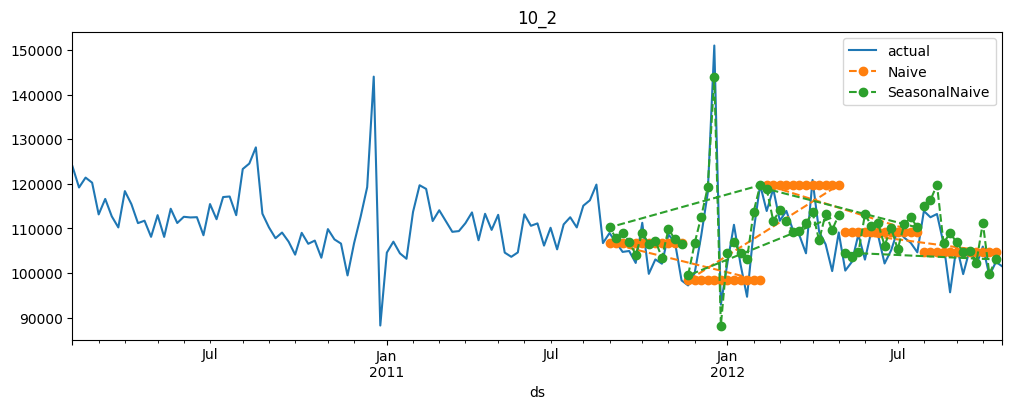

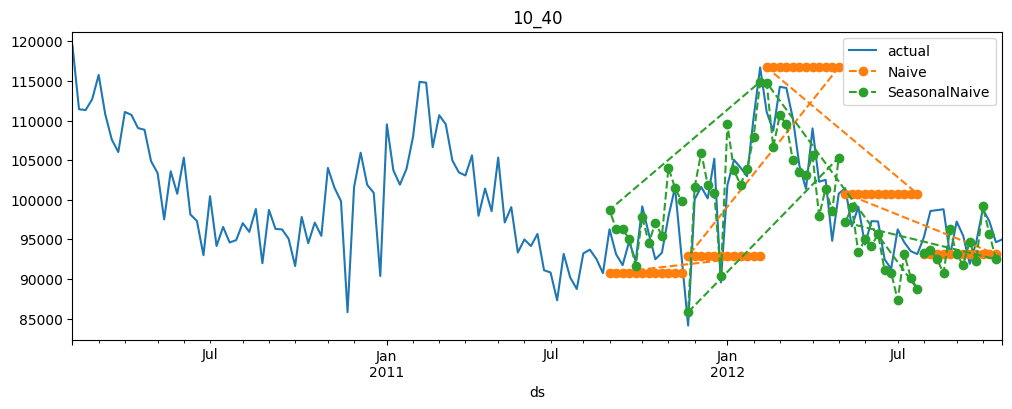

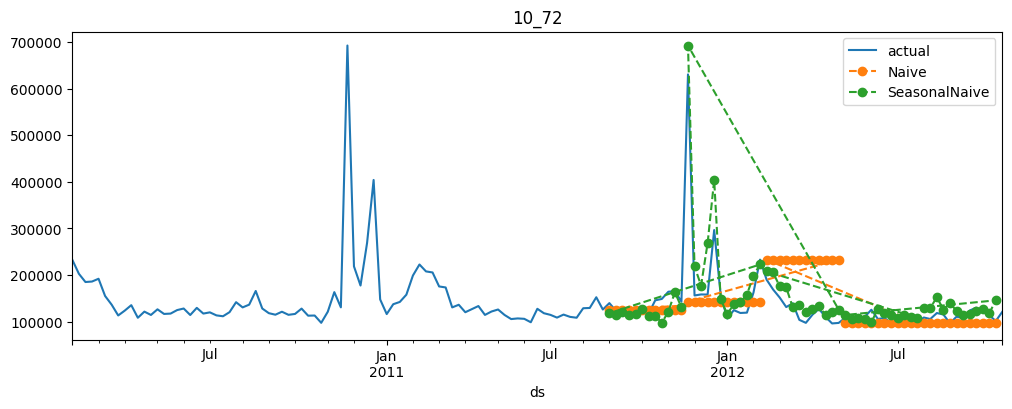

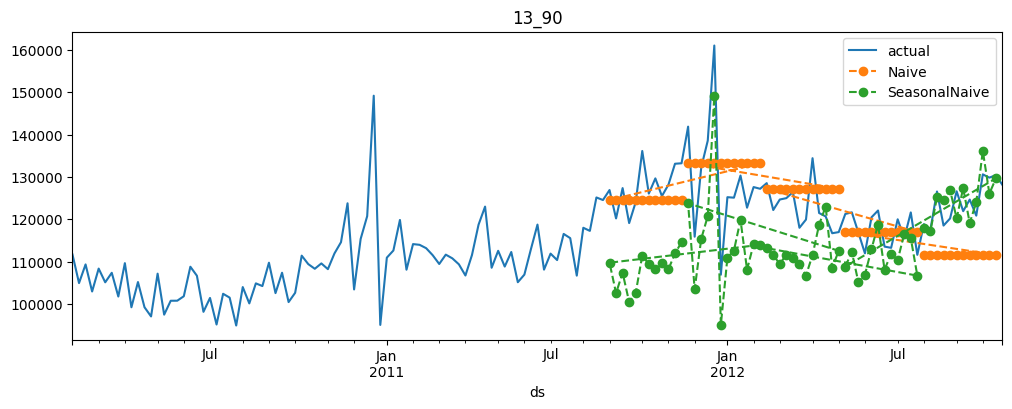

In [11]:
DATA_DIR = "."
Y_PATH = "downsampled_df.csv"
FEATURES_PATH = os.path.join(DATA_DIR, "features.csv")
STORES_PATH = os.path.join(DATA_DIR, "stores.csv")

Y_df_full = pd.read_csv(Y_PATH, parse_dates=["ds"])
features = pd.read_csv(FEATURES_PATH, parse_dates=["Date"])
stores = pd.read_csv(STORES_PATH)

features = features.rename(columns={"Date": "ds", "IsHoliday": "isHoliday"})

# Extract Store and Dept from unique_id
Y_df_full[["Store","Dept"]] = Y_df_full["unique_id"].str.split("_", expand=True).astype(int)

# Merge features
X_df = pd.merge(
    Y_df_full[["unique_id","ds","Store"]].drop_duplicates(),
    features,
    how="left",
    left_on=["Store","ds"],
    right_on=["Store","ds"]
)

# Merge store-level features
X_df = pd.merge(X_df, stores, how="left", on="Store")

exog_cols = ["Temperature","Fuel_Price","CPI","Unemployment","isHoliday","Type","Size"]
for c in exog_cols:
    if c not in X_df.columns:
        print("Warning: feature missing:", c)

X_df = X_df[["unique_id","ds"] + [c for c in exog_cols if c in X_df.columns]]

print("Y_df sample:")
print(Y_df_full.head())
print("\nX_df sample:")
print(X_df.head())

def reindex_series(df_y):
    out = []
    for uid, g in df_y.groupby("unique_id"):
        g = g.set_index("ds").sort_index()
        start = g.index.min()
        end = g.index.max()
        full_idx = pd.date_range(start=start, end=end, freq="W-FRI")
        g = g.reindex(full_idx)
        g.index.name = "ds"
        g["unique_id"] = uid
        out.append(g.reset_index())
    return pd.concat(out, ignore_index=True)

Y_full = reindex_series(Y_df_full[["unique_id","ds","y"]])
print("After reindex, rows:", len(Y_full))
print(Y_full.groupby("unique_id")["y"].apply(lambda s: s.isna().sum()).head())

# Impute y
Y_full["y"] = Y_full.groupby("unique_id")["y"].transform(lambda s: s.ffill().bfill().fillna(0))

h = 12
min_history = 5*h + 12
lens = Y_full.groupby("unique_id").size()
eligible = lens[lens >= min_history].index.tolist()

print("Total series before:", Y_full["unique_id"].nunique())
print("Eligible series after length filter:", len(eligible))

Y_full = Y_full[Y_full["unique_id"].isin(eligible)].copy()

def make_nonoverlapping_folds(df_in, h=12, n_folds=5):
    folds = []
    for uid, g in df_in.groupby("unique_id"):
        max_date = g["ds"].max()
        for i in range(n_folds):
            test_end = max_date - pd.Timedelta(weeks=h*i)
            test_start = max_date - pd.Timedelta(weeks=h*(i+1))
            folds.append({
                "unique_id": uid,
                "fold": i+1,
                "test_start": test_start,
                "test_end": test_end - pd.Timedelta(days=1) + pd.Timedelta(weeks=1)
            })
    folds_df = pd.DataFrame(folds)
    folds_df = folds_df[folds_df["test_start"] < folds_df["test_end"]].copy()
    return folds_df

folds_df = make_nonoverlapping_folds(Y_full, h=h, n_folds=5)
folds_df.head(8)

def mape(y_true, y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    denom = np.where(y_true == 0, np.nan, y_true)
    return np.nanmean(np.abs((y_true - y_pred) / denom)) * 100

def me(y_true, y_pred):
    return np.mean(np.array(y_pred) - np.array(y_true))

def rmse_sklearn(y_true, y_pred):
    return np.sqrt(mean_squared_error(y_true, y_pred))

def mae_sklearn(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

def run_sf_fold(train_df, h=12, models=None, freq="W-FRI", X_train=None):
    sf_local = StatsForecast(models=models, freq=freq, n_jobs=1)
    fcst = sf_local.forecast(df=train_df, h=h)
    return fcst

from tqdm import tqdm

models_to_run = [Naive(), SeasonalNaive(52)]

results = []

for fold in range(1, 6):
    print("Running fold", fold)
    for uid, g in Y_full.groupby("unique_id"):
        frow = folds_df[(folds_df["unique_id"] == uid) & (folds_df["fold"] == fold)]
        if frow.empty:
            continue
        test_start = frow["test_start"].values[0]
        train_g = g[g["ds"] < test_start][["unique_id","ds","y"]]
        test_g = g[(g["ds"] >= test_start) & (g["ds"] < test_start + pd.Timedelta(weeks=h))][["ds","y"]]
        if len(test_g) < h or len(train_g) < 12:
            continue
        try:
            fcst = run_sf_fold(train_g, h=h, models=models_to_run, freq="W-FRI")
        except Exception as e:
            print("StatsForecast error for uid", uid, e)
            continue

        for model in models_to_run:
            model_name = model.__class__.__name__
            mcols = fcst[["ds", model_name]].set_index("ds")
            joined = test_g.set_index("ds").join(mcols, how="left")
            joined = joined.reset_index().rename(columns={model_name: "yhat"})
            joined["unique_id"] = uid
            joined["fold"] = fold
            joined["model"] = model_name
            results.append(joined[["unique_id","fold","ds","model","y","yhat"]])

cv_results_df = pd.concat(results, ignore_index=True)
print("cv results rows:", len(cv_results_df))

dfm = cv_results_df.copy()
agg = dfm.groupby(["unique_id","model"]).apply(
    lambda g: pd.Series({
        "ME": me(g["y"], g["yhat"]),
        "MAE": mae_sklearn(g["y"], g["yhat"]),
        "RMSE": rmse_sklearn(g["y"], g["yhat"]),
        "MAPE": mape(g["y"], g["yhat"])
    })
).reset_index()

print(agg.head())
agg.to_csv("per_series_model_metrics.csv", index=False)

wins = {}
metrics_list = ["ME","MAE","RMSE","MAPE"]
for met in metrics_list:
    winners = agg.loc[agg.groupby("unique_id")[met].idxmin()][["unique_id","model",met]]
    winners = winners.rename(columns={"model": "winner"})
    wins[met] = (
        winners["winner"]
        .value_counts()
        .rename_axis("model")
        .reset_index(name="wins")
        .sort_values("wins", ascending=False)
    )
    print("Top winners by", met)
    print(wins[met].head())

def plot_series_predictions(uid, df_predictions, df_actual):
    plt.figure(figsize=(12,4))
    s = df_actual[df_actual["unique_id"] == uid].set_index("ds")["y"]
    s.plot(label="actual")
    preds = df_predictions[(df_predictions["unique_id"] == uid)]
    for model_name, grp in preds.groupby("model"):
        grp = grp.set_index("ds")["yhat"]
        grp.plot(marker="o", linestyle="--", label=model_name)
    plt.title(uid)
    plt.legend()
    plt.show()

u_list = cv_results_df["unique_id"].unique()[:4]
for uid in u_list:
    plot_series_predictions(uid, cv_results_df, Y_full)

### 7) Optional Extra MLF Snippet

In [ ]:
model_lgb = LGBMRegressor(n_estimators=200)

fcst_example = MLForecast(
    models=[("lgb", model_lgb)],
    freq="W-FRI",
    lags=[1,52],
    date_features=["month","week"],
)

# fcst_example.fit(train_df, X_df=exog_train)
# preds = fcst_example.predict(h=h)


### 8) Save Key Outputs

In [ ]:
cv_results_df.to_csv("cv_predictions_full.csv", index=False)
agg.to_csv("per_series_model_metrics.csv", index=False)
for met in metrics_list:
    wins[met].to_csv(f"winner_counts_{met}.csv", index=False)

print("Saved CSVs.")